__What is transfer learning?__ <br>
_Transfer learning, used in machine learning, is the reuse of a pre-trained model on a new problem. In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another. For example, in training a classifier to predict whether an image contains food, you could use the knowledge it gained during training to recognize drinks._

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

In [2]:
# set up device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

__Creating DataLoaders__

In [3]:
# get data path

from pathlib import Path

data_path = Path("going_modular/data/")
image_path = data_path / "pizza_steak_sushi"

# setting directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/pizza_steak_sushi/train'),
 PosixPath('going_modular/data/pizza_steak_sushi/test'))

When loading data, an important aspect to consider is **how to transform it**. There are two main approaches to creating data transformations:

1. **Manually create transforms**: You define the specific transformations that your data should undergo.
2. **Automatically create transforms**: The transformations are defined by the model you intend to use.

**Important point**: When using a pretrained model, it is crucial that the data (including your custom data) is **transformed** in the same way as the data on which the model was originally trained. This ensures compatibility and optimal performance of the pretrained model with your dataset.

1. __For Manual Transformation__ we can find the transformation in the below link <br>
__https://pytorch.org/vision/0.12/models.html__

In [4]:
# make transform
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform  = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15afdad90>,
 ['pizza', 'steak', 'sushi'])

2. __For Automatic transformation__, from `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using. <br>
__http://pytorch.org/vision/stable/models.html__

In [5]:
# getting a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT: best available weights"
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [6]:
# get the transform used to create these pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
# from this automatic transforms creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15afeb090>,
 ['pizza', 'steak', 'sushi'])

## Setting Up a Pretrained Model

In [8]:
# old way of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# new method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
model.classifier # by def the model have 1000 classes, we have to change it according to our problem

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
# try getting summary of the model using torchinfo
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential: 2-2  

Now instead of using the model as is, **feature extraction** is mostly used 
* __Description__: take the underlying patterns (weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 
* __What Happend__: most of the layers in the original model remain frozen during training (only the top 1-3 layers get updated.

So in the above summary we will have to froze all the layers in between and only keep the classifier as trainable.<br> So all layers should have False in trainable columns except the last layer

In [11]:
# froze all the layers
for param in model.features.parameters():
    param.requires_grad=False

torch.manual_seed(42)

# we have to update the last layer
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names))
).to(device)

In [12]:
# now if we again check summary 
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

## Training Model

In [13]:
# setup loss func
loss_fn = nn.CrossEntropyLoss()

# setup optimizer
optimizer = torch.optim.Adam(params=model.parameters())

In [14]:
from going_modular import engine

# set up random seds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# saving the result
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

Epoch:0	Train_Loss:1.0823	Train_Acc:40.6250	Test_Loss:0.8991	Test_Acc:59.0909
Epoch:1	Train_Loss:0.8564	Train_Acc:76.9531	Test_Loss:0.7927	Test_Acc:84.5644
Epoch:2	Train_Loss:0.7914	Train_Acc:78.9062	Test_Loss:0.7373	Test_Acc:85.6061
Epoch:3	Train_Loss:0.7206	Train_Acc:75.0000	Test_Loss:0.6338	Test_Acc:87.5947
Epoch:4	Train_Loss:0.6368	Train_Acc:78.1250	Test_Loss:0.6190	Test_Acc:86.6477


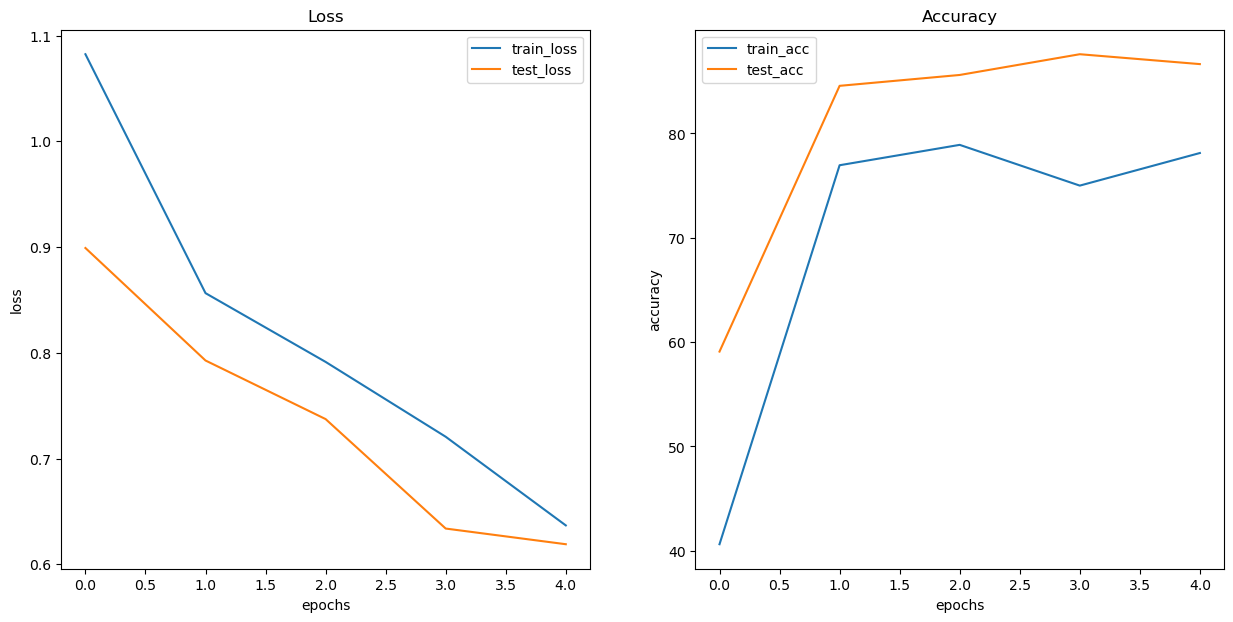

In [15]:
# plotting loss curves

import os
import sys

# Adding the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

try: 
    from helper_functions import plot_loss_curve
except ImportError:
    print(f"[INFO] Couldn't find helper_functions.py, downloading...")
    helper_functions_path = os.path.join(parent_dir, "helper_functions.py")
    with open(helper_functions_path, "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/pratik-kadlak/Pytorch/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curve
    
plot_loss_curve(results)

## Making Prediction
We have to make sure that our test/custom data is:
* same shape - images need to be same shape as model was trained on
* same datatype - custom data should be in the same data type
* same device - custom data should be on the same device
* same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

In [17]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        img_dir: str,
                        class_names: List[str],
                        img_size: Tuple[int, int] = (224, 224), 
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
    # open image with PIL
    img = Image.open(img_dir)
    
    # create a transform is one doesn't exist
    if transform == None:
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    
    # transform the image and unsqueeze for extra batch dimension
    transformed_img = transform(img).unsqueeze(dim=0)  
        
    # putting model to the correct device
    model = model.to(device)
    transformed_img = transformed_img.to(device)
    
    # prediction
    model.eval()
    with torch.inference_mode():
        y_logits = model(transformed_img)
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        
    # plot the image
    plt.figure()
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"Pred: {class_names[y_pred]}")

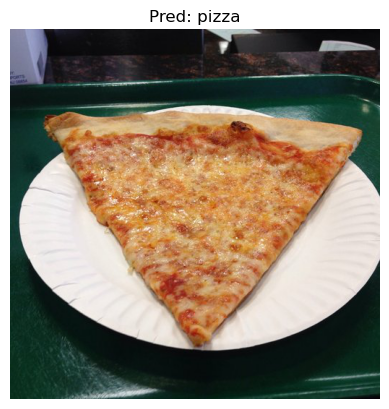

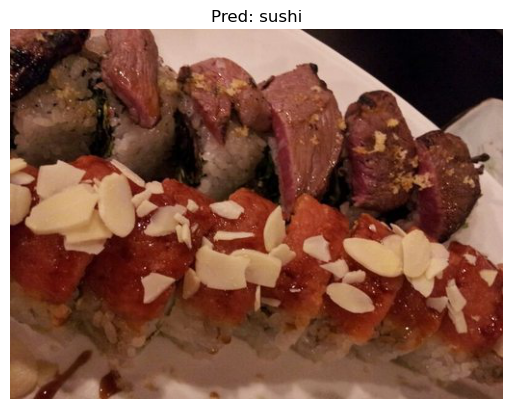

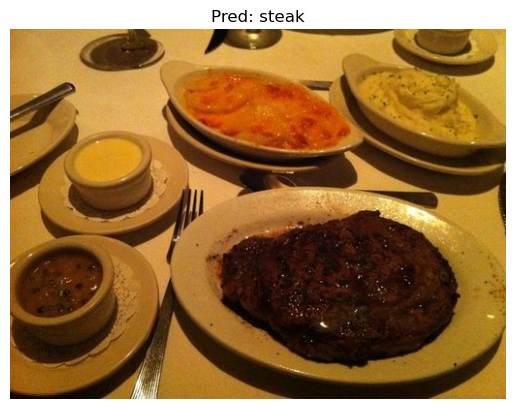

In [22]:
import random
num_images = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_images_sample = random.sample(population=test_img_path_list,
                                   k = num_images)

for img_dir in test_images_sample:
    pred_and_plot_image(model=model,
                        img_dir=img_dir,
                        class_names=class_names,
                        img_size=(224, 224), 
                        transform=None,
                        device=device)